<a href="https://colab.research.google.com/github/vu211fa18067/Data-Extraction-and-Analysis-NLP/blob/main/NSTcoursera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the model


In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
model=VGG19(
    include_top=False,
    weights='imagenet')
model.trainable=False
model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

###import libraries and helper functions


In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

#####Image processing and display


In [ ]:
def load_and_process_image(image_path):
  img=load_img(image_path)
  img=img_to_array(img)
  img=preprocess_input(img)
  img=np.expand_dims(img,axis=0)
  return img

In [ ]:
def deprocess(x):
  x[:,:,0]+=103.939
  x[:,:,1]+=116.779
  x[:,:,2]+=123.68
  x=x[:,:,::-1]
  x=np.clip(x,0,255).astype('uint8')
  return x
def display_image(image):
  if len(image.shape)==4:
    img=np.squeeze(image,axis=0)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  return


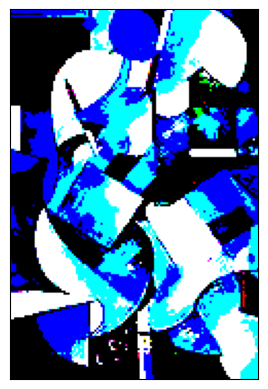

In [ ]:
display_image(load_and_process_image("style1.jpeg"))

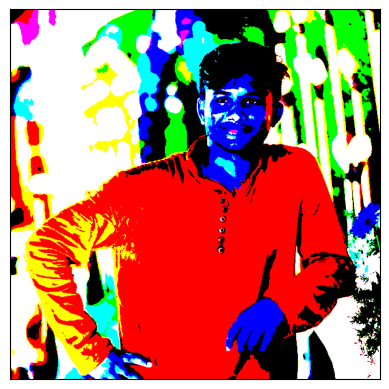

In [ ]:
display_image(load_and_process_image("20220810_133540.jpg"))

####content and style model

In [ ]:
content_layer='block5_conv2'
style_layers=[
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]
content_model=Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)
style_models=[Model(inputs=model.input,
                   outputs=model.get_layer(layer).output) for layer in style_layers]

###content cost

In [ ]:
def content_cost(content,generated):
  a_C=content_model(content)
  a_G=content_model(generated)
  cost=tf.reduce_mean(tf.square(a_C-a_G))
  return cost

###Gram matrix

In [ ]:
def gram_matrix(A):
  n_C=int(A.shape[-1])
  a=tf.reshape(A,[-1,n_C])
  n=tf.shape(a)[0]
  G=tf.matmul(a,a,transpose_a=True)
  return G/tf.cast(n,tf.float32)


###style cost

In [ ]:
lam=1./len(style_models)
def style_cost(style,generated):
  J_style=0
  for style_model in style_models:
    a_S=style_model(style)
    a_G=style_model(generated)
    GS=gram_matrix(a_S)
    GG=gram_matrix(a_G)
    current_cost=tf.reduce_mean(tf.square(GS-GG))
    J_style+=current_cost*lam
  return J_style


###Training Loop

In [ ]:
import time
generated_images=[]
def training_loop(content_path,style_path,iterations=20,alpha=10.,beta=20.):
  content=load_and_process_image(content_path)
  style=load_and_process_image(style_path)

  generated = tf.Variable(content, dtype=tf.float32)
  opt=tf.keras.optimizers.Adam(learning_rate=7.)
  best_cost=1e12+0.1
  best_image=None
  start_time=time.time()
  for i in range(iterations):
    with tf.GradientTape()as tape:
      J_content=content_cost(content,generated)
      J_style=style_cost(style,generated)
      J_total = alpha * content_cost(content, generated) + beta * style_cost(style, generated)
    grads=tape.gradient(J_total,generated)
    opt.apply_gradients([(grads,generated)])

    if J_total<best_cost:
      best_cost=J_total
      best_image=generated.numpy()
    print("cost at {}: {}. Time elapsed: {}".format(i,J_total,time.time()-start_time))
    generated_images.append(generated.numpy())
  return best_image




In [ ]:
best_image=training_loop("20220810_133540.jpg","style1.jpeg")

cost at 0: 35201835008.0. Time elapsed: 12.983968257904053
cost at 1: 29082093568.0. Time elapsed: 14.031656265258789
cost at 2: 20340015104.0. Time elapsed: 15.084688425064087
cost at 3: 13610802176.0. Time elapsed: 16.10869860649109
cost at 4: 11801214976.0. Time elapsed: 17.133150815963745
cost at 5: 11396584448.0. Time elapsed: 18.16274118423462
cost at 6: 9476491264.0. Time elapsed: 19.19567036628723
cost at 7: 7650442752.0. Time elapsed: 20.223776817321777
cost at 8: 6692673536.0. Time elapsed: 21.255780935287476
cost at 9: 6181734400.0. Time elapsed: 22.28336215019226
cost at 10: 5704491520.0. Time elapsed: 23.320854663848877
cost at 11: 5198043648.0. Time elapsed: 24.34580087661743
cost at 12: 4733082624.0. Time elapsed: 25.391393899917603
cost at 13: 4326752768.0. Time elapsed: 26.4439959526062
cost at 14: 3944584448.0. Time elapsed: 27.49670958518982
cost at 15: 3570133504.0. Time elapsed: 28.53015398979187
cost at 16: 3225067776.0. Time elapsed: 29.56457781791687
cost at 17:

##plot the result


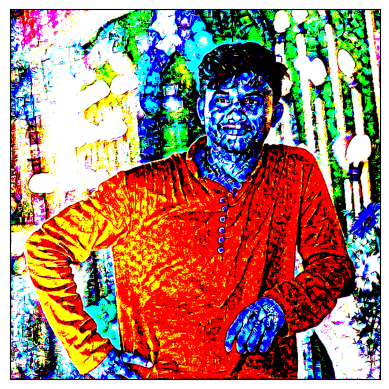

In [ ]:
display_image(best_image)

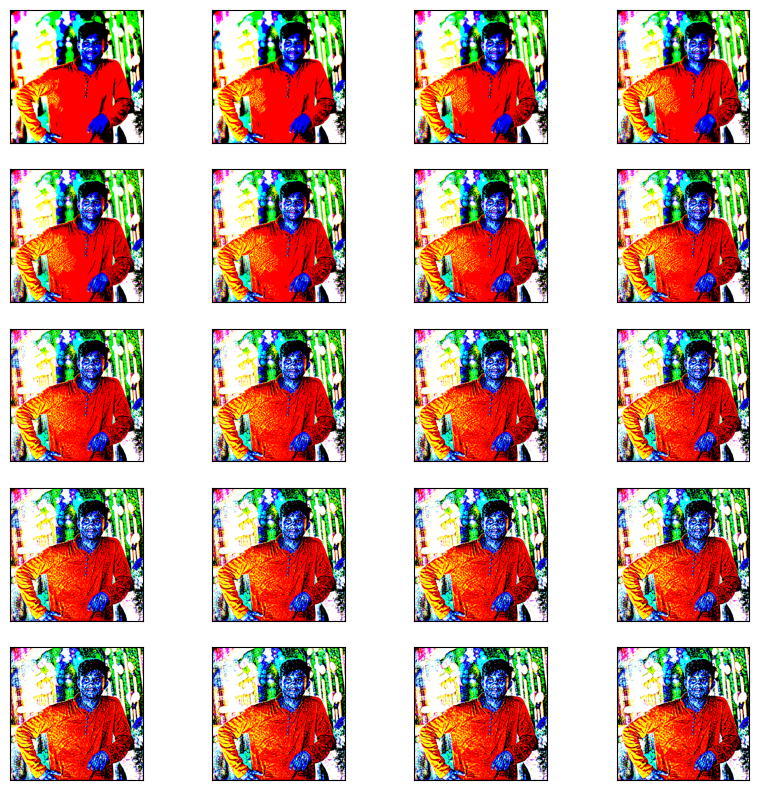

In [ ]:
plt.figure(figsize=(10,10))
for i in range(20):
  plt.subplot(5,4,i+1)
  display_image(generated_images[i])
plt.show()